In [87]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pickle
import datetime
import pandas as pd
import itertools

from torch.utils.data import DataLoader, Subset, ConcatDataset

from torchvision.models import resnet50, ResNet50_Weights


cudnn.benchmark = True

# Data

## Load all datasets

In [10]:
data_dir = os.path.join('data', 'Alzheimer_s Dataset')
synth_dir = os.path.join('data','synth')

In [11]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

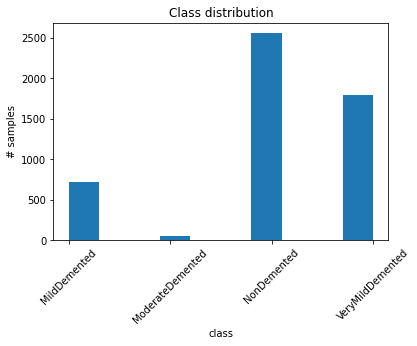

In [152]:
real_train_class_idx = {v: k for k,v in real_train_dataset.class_to_idx.items()}
real_train_target = [real_train_class_idx[t] for t in real_train_dataset.targets]

plt.hist(real_train_target)
plt.title('Class distribution')
plt.ylabel('# samples')
plt.xlabel('class')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees

In [12]:
real_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])

synth_dataset_train = datasets.ImageFolder(os.path.join(synth_dir, 'train'),
                                     data_transforms['train'])

synth_dataset_test = datasets.ImageFolder(os.path.join(synth_dir, 'test'),
                                     data_transforms['test'])

real_synth_train = ConcatDataset([real_train_dataset, synth_dataset_train])

real_test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'),
                                          data_transforms['test'])

## Prepare and select datasets for training models

In [13]:
all_training_sets = {
    'real': real_train_dataset,
    'real_synth': real_synth_train,
    'synth': synth_dataset_train
}

In [7]:
TRAIN_SET_NAME = 'real_synth'
image_datasets = {
    'train': all_training_sets[TRAIN_SET_NAME],
    'test': real_test_dataset
}

In [8]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=128,
                                              shuffle=True,
                                              num_workers=4)
               for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['test'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training

## Code for viz

In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

NameError: name 'dataloaders' is not defined

## Code for inference

In [53]:
def inference(model, dataloader, device, criterion = nn.CrossEntropyLoss()):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        #optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
        
    return float(epoch_loss), float(epoch_acc)

## code for training

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    metrics_loss = []
    metrics_acc = []
    metrics = {'train': {'loss': [], 'accuracy': []},
               'test':  {'loss': [], 'accuracy': []},
              }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            metrics[phase]['loss'].append(float(epoch_loss))
            metrics[phase]['accuracy'].append(float(epoch_acc))

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, {'loss': metrics_loss, 'accuracy': metrics_acc}

## Train

In [13]:
weights = ResNet50_Weights.IMAGENET1K_V2
preprocess = weights.transforms()

model_ft = resnet50(weights=weights)
num_ftrs = model_ft.fc.in_features

In [131]:
help(lr_scheduler.StepLR)

Help on class StepLR in module torch.optim.lr_scheduler:

class StepLR(_LRScheduler)
 |  StepLR(optimizer, step_size, gamma=0.1, last_epoch=-1, verbose=False)
 |  
 |  Decays the learning rate of each parameter group by gamma every
 |  step_size epochs. Notice that such decay can happen simultaneously with
 |  other changes to the learning rate from outside this scheduler. When
 |  last_epoch=-1, sets initial lr as lr.
 |  
 |  Args:
 |      optimizer (Optimizer): Wrapped optimizer.
 |      step_size (int): Period of learning rate decay.
 |      gamma (float): Multiplicative factor of learning rate decay.
 |          Default: 0.1.
 |      last_epoch (int): The index of last epoch. Default: -1.
 |      verbose (bool): If ``True``, prints a message to stdout for
 |          each update. Default: ``False``.
 |  
 |  Example:
 |      >>> # Assuming optimizer uses lr = 0.05 for all groups
 |      >>> # lr = 0.05     if epoch < 30
 |      >>> # lr = 0.005    if 30 <= epoch < 60
 |      >>> #

In [14]:
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [16]:
model_ft, metrics = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
train Loss: 0.9222 Acc: 0.6564
test Loss: 1.0335 Acc: 0.5016

Epoch 1/99
----------
train Loss: 0.3487 Acc: 0.8591
test Loss: 1.0275 Acc: 0.5008

Epoch 2/99
----------
train Loss: 0.2670 Acc: 0.8821
test Loss: 0.9449 Acc: 0.5094

Epoch 3/99
----------
train Loss: 0.2433 Acc: 0.8881
test Loss: 0.9221 Acc: 0.5195

Epoch 4/99
----------
train Loss: 0.2260 Acc: 0.8973
test Loss: 0.9555 Acc: 0.5227

Epoch 5/99
----------
train Loss: 0.2200 Acc: 0.8990
test Loss: 0.8928 Acc: 0.5539

Epoch 6/99
----------
train Loss: 0.2098 Acc: 0.9039
test Loss: 0.9500 Acc: 0.5367

Epoch 7/99
----------
train Loss: 0.2046 Acc: 0.9041
test Loss: 0.8942 Acc: 0.5648

Epoch 8/99
----------
train Loss: 0.2021 Acc: 0.9058
test Loss: 0.9046 Acc: 0.5516

Epoch 9/99
----------
train Loss: 0.2049 Acc: 0.9044
test Loss: 0.8918 Acc: 0.5586

Epoch 10/99
----------
train Loss: 0.2023 Acc: 0.9062
test Loss: 0.8872 Acc: 0.5602

Epoch 11/99
----------
train Loss: 0.2014 Acc: 0.9061
test Loss: 0.8954 Acc

## Store model and results

In [17]:
fn_datetime_prefix = datetime.datetime.now().strftime(f'%Y_%m_%d_%H_%M')
torch.save(model_ft, f'{fn_datetime_prefix}__{TRAIN_SET_NAME}_model.pt')
with open(f'{fn_datetime_prefix}__{TRAIN_SET_NAME}_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)
    

## Results compilation

In [38]:
pd.DataFrame(data={'train dataset': ['real','synthetic', 'synthetic', 'real+synth'],                   
                   'best train acc': [0.5695, 0.9874, 0.9874, 0.9069],
                   'best_test_acc': [0.548438, 0.1398, 0.9096, 0.5820],
                   'epochs': [100, 100, 100, 100],
                   'test set': ['real', 'real', 'synthetic', 'real']
                  }
            )

,train dataset,best train acc,best_test_acc,epochs,test set
0,real,0.5695,0.548438,100,real
1,synthetic,0.9874,0.139800,100,real
2,synthetic,0.9874,0.909600,100,synthetic
3,real+synth,0.9069,0.582000,100,real


# Inference from loaded model

In [61]:
models = !ls *.pt

In [ ]:
for i,fn in enumerate(models):
    print(i, fn)

0 2022_07_23_01_27__real_model.pt
1 2022_07_23_07_58__synth_model.pt
2 2022_07_23_11_33__real_synth_model.pt
3 MildDemented_discriminator.pt
4 MildDemented_generator.pt
5 ModerateDemented_discriminator.pt
6 ModerateDemented_generator.pt
7 NonDemented_discriminator.pt
8 NonDemented_generator.pt
9 VeryMildDemented_discriminator.pt
10 VeryMildDemented_generator.pt


In [92]:
models_fn = [
    '2022_07_23_01_27__real_model.pt',
    '2022_07_23_07_58__synth_model.pt',
    '2022_07_23_11_33__real_synth_model.pt'
]

datasets = {
    'real train': real_train_dataset,
    'synth train': synth_dataset_train,
    'synth test': synth_dataset_test,
    'real synth train': real_synth_train,
    'real test': real_test_dataset
}

In [74]:
model_fn = models[2]
chosen_dataset = synth_dataset_test

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [88]:
def run_inference(model_fn: str, dataset):
    model = torch.load(model_fn)

    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=128,
                                             shuffle=True,
                                             num_workers=4)

    class_names = real_train_dataset.classes
    
    return inference(model, dataloader, device)

In [75]:
model = torch.load(model_fn)

dataloader = torch.utils.data.DataLoader(chosen_dataset,
                                         batch_size=128,
                                         shuffle=True,
                                         num_workers=4)

class_names = real_train_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [114]:
results = pd.DataFrame(itertools.product(models_fn, datasets.keys()), columns=['model', 'dataset'])
results['accuracy'] = -1
results['loss'] = -1

for i, model_dataset in enumerate(itertools.product(models_fn, datasets.keys())):
    model_fn, dataset_name = model_dataset
    loss, acc = run_inference(model_fn, datasets[dataset_name])
    results.at[i, 'loss'] = loss
    results.at[i, 'accuracy'] = acc
    print(i, model_fn, dataset_name, acc)
    #print(results)
    

0 2022_07_23_01_27__real_model.pt real train 0.5663803201874268
1 2022_07_23_01_27__real_model.pt synth train 0.252
2 2022_07_23_01_27__real_model.pt synth test 0.2595
3 2022_07_23_01_27__real_model.pt real synth train 0.3184061778520818
4 2022_07_23_01_27__real_model.pt real test 0.5375
5 2022_07_23_07_58__synth_model.pt real train 0.138227254978524
6 2022_07_23_07_58__synth_model.pt synth train 0.97465
7 2022_07_23_07_58__synth_model.pt synth test 0.9965
8 2022_07_23_07_58__synth_model.pt real synth train 0.8049916407929304
9 2022_07_23_07_58__synth_model.pt real test 0.13984375000000002
10 2022_07_23_11_33__real_synth_model.pt real train 0.5999609527528309
11 2022_07_23_11_33__real_synth_model.pt synth train 0.9900500000000001
12 2022_07_23_11_33__real_synth_model.pt synth test 1.0
13 2022_07_23_11_33__real_synth_model.pt real synth train 0.9125467717538411
14 2022_07_23_11_33__real_synth_model.pt real test 0.58203125


In [154]:
results

,model,dataset,accuracy,loss
0,2022_07_23_01_27__real_model.pt,real train,0.566380,0.882146
1,2022_07_23_01_27__real_model.pt,synth train,0.252000,1.721778
2,2022_07_23_01_27__real_model.pt,synth test,0.259500,1.695184
3,2022_07_23_01_27__real_model.pt,real synth train,0.318406,1.550967
4,2022_07_23_01_27__real_model.pt,real test,0.537500,0.914505
5,2022_07_23_07_58__synth_model.pt,real train,0.138227,7.253116
6,2022_07_23_07_58__synth_model.pt,synth train,0.974650,0.078957
7,2022_07_23_07_58__synth_model.pt,synth test,0.996500,0.022740
8,2022_07_23_07_58__synth_model.pt,real synth train,0.804992,1.539548
9,2022_07_23_07_58__synth_model.pt,real test,0.139844,7.768363


In [129]:
results.to_excel('models_results.xlsx')

# ------ END ------